<a href="https://colab.research.google.com/github/sankethks25/Deep-Learning/blob/main/Cat_Dog_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connecting to Kaggle

In [1]:
from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Downloading the Dataset

In [2]:
!kaggle datasets download -d fushenggg/3-class-cat-dog-car-dataset

 97% 119M/123M [00:00<00:00, 126MB/s]
100% 123M/123M [00:01<00:00, 123MB/s]


In [ ]:
!unzip /content/3-class-cat-dog-car-dataset.zip

### Importing Dependencies

In [1]:
import numpy as np
import pandas as pd

import os
from pathlib import Path

import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split


from tqdm import tqdm

### Clean Function

In [2]:
def clean_data(fname):

  target_size = (150, 150)
  img = plt.imread(fname)

  img = cv2.resize(img, target_size) 

  # Normalization
  img = img/255.0

  return img

### Taking Dataset

In [3]:
data_dir = Path(r"/content/cats_dogs_cars/cats_dogs_cars/data")

labels = {"car": 0, "cat": 1, "dog": 2}

X = []

y = []

for fname in tqdm(os.listdir(data_dir)):

  img = clean_data(data_dir / fname)

  X.extend([img])
  y.extend([labels[fname.split(".")[0]]])

X = np.array(X)
y = np.array(y)

100%|██████████| 3000/3000 [00:10<00:00, 277.19it/s]


### Splitting Data into Train/Test/Val

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True, stratify=y)

### Model Building

In [5]:
def build_model():

  inputs = Input(shape=X_train[0].shape, name="Input Layer")

  x = Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding="valid", activation="relu")(inputs)
  x = MaxPool2D(pool_size=(2,2))(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), padding="valid", activation="relu")(x)
  x = MaxPool2D(pool_size=(2,2))(x)
  x = BatchNormalization()(x)

  x = Flatten()(x)
  x = Dense(units=512, activation="relu")(x)

  outputs = Dense(units=3, activation="softmax")(x)

  # Building Model
  model = Model(inputs=inputs, outputs=outputs)

  model.summary()

  tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=True, dpi=300, expand_nested=True,
                            show_layer_activations=True)
  
  return model

In [6]:
model = build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 146, 146, 256)     19456     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 256)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       819328    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0     

### Model Compiling

In [7]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### Callbacks

In [8]:
def callbacks():

  earlystopping = EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=1, restore_best_weights=True)

  checkpoint = ModelCheckpoint("model.hdf5", monitor='val_loss', verbose=1, save_best_only=True,  mode='min', save_freq='epoch')

  lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0)

  return [earlystopping, checkpoint, lr]

### Model Training

In [9]:
model.fit(X_train, y_train, epochs=30, verbose=1, validation_data=(X_test, y_test),
          batch_size=32, shuffle=True, validation_batch_size=32, callbacks=callbacks())

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 41.7523 - accuracy: 0.5913
Epoch 1: val_loss improved from inf to 41.57022, saving model to model.hdf5
75/75 [==============================] - 44s 439ms/step - loss: 41.7523 - accuracy: 0.5913 - val_loss: 41.5702 - val_accuracy: 0.4833 - lr: 0.0010
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 11.1166 - accuracy: 0.7154
Epoch 2: val_loss improved from 41.57022 to 18.84865, saving model to model.hdf5
75/75 [==============================] - 26s 347ms/step - loss: 11.1166 - accuracy: 0.7154 - val_loss: 18.8486 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 3.3705 - accuracy: 0.7792
Epoch 3: val_loss improved from 18.84865 to 9.24806, saving model to model.hdf5
75/75 [==============================] - 26s 342ms/step - loss: 3.3705 - accuracy: 0.7792 - val_loss: 9.2481 - val_accuracy: 0.3783 - lr: 0.0010
Epoch 4/30
75/75 [======================

### Model Prediction

In [12]:
def predict(fname):

  classes = ["car", "cat", "dog"]

  test = clean_data(fname)

  lmodel = tf.keras.models.load_model("/content/model.hdf5")

  pred = lmodel.predict(np.array([test, ]))

  pred = np.argmax(pred, axis=-1)[0]

  pred = classes[pred]

  plt.title(f"Predicted Class is {pred}")

  plt.imshow(test)

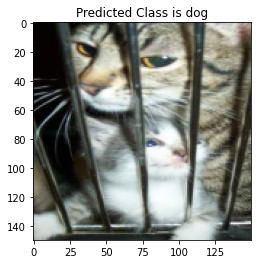

In [19]:
predict("/content/cats_dogs_cars/cats_dogs_cars/test/10.jpg")